pici mag coop
közvetlen szomszédság D
mantle maradék p valség fix

In [1]:
#Import
#Libraries

import networkx as nx
%pylab inline
import numpy as np
import time

Populating the interactive namespace from numpy and matplotlib


In [200]:
#Network properties
#structure, variables

def newNetwork(N,m,F,P):

    net = nx.barabasi_albert_graph(N,m)
    net.graph= net.graph_attr_dict_factory(needPayoff=set(net.nodes),needStrategy=set(net.nodes),
                                           fixedNodes=set(),shellLo=0,
                                          mantle=set(net.nodes),)
    
    maxD=0
    maxNode=0
    attr= dict()
    for node in net.nodes():
        nodeDict=dict()
        nodeDict["coop"]=0
        nodeDict["payoff"]=0#első draw
        nodeDict["fixed"]=False
        attr[node]=nodeDict
        if nx.degree(net,node)> maxD:
            maxD = nx.degree(net,node)
            maxNode=node

    nx.set_node_attributes(net, attr)
    
    
    
    
    #random fixálás
    if F>N:
        F=N
    
    net.nodes[maxNode]["fixed"]=True
    net.nodes[maxNode]["coop"]=1
    net.graph["fixedNodes"].add(maxNode)
    
    
    f=1
    for neighbor in nx.neighbors(net,maxNode):
        net.nodes[neighbor]["fixed"]=True
        net.nodes[neighbor]["coop"]=1
        net.graph["fixedNodes"].add(neighbor)
        f+=1  
        if f==F:
            break
            
    shells = []
    shells.append(net.graph["fixedNodes"])
    
    """rest=set(net.nodes())
    rest.discard(shells[-1])
    
    while len(rest)!=0:
        for node in shell[-1]:
            """
    
    shell2=[]
    
    for node in net.graph["fixedNodes"]:
        for neighbor in nx.neighbors(net,node):
            net.graph["mantle"].discard(neighbor)
            if not neighbor in net.graph["fixedNodes"]:
                shell2.append(neighbor)
            
    shells.append(shell2)
    shells.append(net.graph["mantle"])
    net.graph["shellLO"]=nx.shell_layout(net,shells)

        
    for node in net.graph["mantle"]:
        if P> random.random():
            net.nodes[node]["fixed"]=True
            net.nodes[node]["coop"]=1
            net.graph["fixedNodes"].add(node)
    
    
            
    return net

def getCoopRatio (net):
    
    if F==len(net.nodes):
        return 1
    
    coopSum=0
    for node in net.nodes:
        if not net.nodes[node]["fixed"]:
            coopSum+=net.nodes[node]["coop"]
            
    return coopSum/(len(net.nodes)-F)
        


In [3]:
#Interaction (Game)
#one moment in the evolution of the network, PD matrix, link weight, payoff, 
b=1.1

def payNode (net,node):
    payoffMatrix=[[1,0],[b,0]]
    self = int (net.nodes[node]["coop"]==0)#fordítva kell, mert a payoff matrix első sora a coop
    
    payoff=0
    for neighbor in net.neighbors(node):#összegzi a payoffokat, a kooperáció adja az indexet a mátrixhoz
        opponent= int (net.nodes[neighbor]["coop"]==0)
        payoff+=payoffMatrix[self][opponent]
        
    net.nodes[node]["payoff"]=payoff #új attribútomot kap a nódus
    


In [4]:
#Evolution
#discreet or continuous, random or all, long-range effect

def updatePayoff(net):
    for node in net.graph["needPayoff"]:
        payNode(net,node)
        
def updateNode (net,node,newNeedPayoff):#proportional, összedja az összeset, 1D geometriai valószínűség, szakaszok, random hossz 0 és sum közt
    neighborSum=0
    for neighbor in net.neighbors(node):
        if net.nodes[neighbor]["payoff"]>=net.nodes[node]["payoff"]:
            neighborSum+=net.nodes[neighbor]["payoff"]
    if neighborSum==0:
        return
    
    R = np.random.random()*neighborSum
    s=0
    for neighbor in net.neighbors(node):
        if net.nodes[neighbor]["payoff"]>=net.nodes[node]["payoff"]:
            s+=(net.nodes[neighbor]["payoff"]-net.nodes[node]["payoff"])
            if s>=R:
                if net.nodes[node]["coop"]!= net.nodes[neighbor]["oldCoop"]:
                    net.nodes[node]["coop"]= net.nodes[neighbor]["oldCoop"]
                    for NN in net.neighbors(node):
                            newNeedPayoff.add(NN)

                return        
    
    
def updateStrategies(net):
    newNeedPayoff=set()
    
    for node in net.graph["needStrategy"]:
        net.nodes[node]["oldCoop"]=net.nodes[node]["coop"]
    
    for node in net.graph["needStrategy"]:
        if net.nodes[node]["fixed"]==False:
            updateNode(net,node,newNeedPayoff)
        
    net.graph["needPayoff"]=newNeedPayoff
    
    newNeedStrategy=net.graph["needStrategy"].union(newNeedPayoff).difference(net.graph["fixedNodes"])
    
    removeNodes=set()
    
    for node in newNeedStrategy:
        if sameStrat(net,node):
            removeNodes.add(node)
    
    newNeedStrategy=newNeedStrategy.difference(removeNodes)
    net.graph["needStrategy"]=newNeedStrategy

        
def sameStrat (net,node):
    for neighbor in net.neighbors(node):
        if net.nodes[neighbor]["coop"]!=net.nodes[node]["coop"]:
            return False
    return True

def nextRound (G):
    #startTime= time.time()
    updatePayoff(G)
    updateStrategies(G)
    #draw(G)
    #print (time.time()-startTime)
    
def simulate (G):
    netChanging = True
    i=0
    while (i<50 and getCoopRatio(G)!=1):
        #prevG= [ G.nodes[node]['coop'] for node in G.nodes ]
        
        nextRound(G)

        #if [ G.nodes[node]['coop'] for node in G.nodes ] == prevG or i==25:
        #    netChanging=False
        i+=1
        
    #print(i)
    return i
            

In [115]:
#Output
#variables, graphs of change, multiple simulations


def draw(net):
    color=[]
    labels={}#ennek dictnek kell lennie
    for node in net.nodes():
        if net.nodes[node]["fixed"]:
            color.append("gold")
        elif net.nodes[node]["coop"]:
            color.append("green")
        else:
            color.append("red")
            
        labels[node]=str(node) + ": " + str(float('%.2f' %net.nodes[node]["payoff"]))

   
    figsize(10,10)
   
    netLayout=net.graph["shellLO"]#""",pos=nodePos,weight="None"""")
    nx.draw_networkx(net,netLayout,dim=2,node_color=color,cmap="RdYlGn",node_size=40,edge_color="grey",width=0.5,with_labels=False)#minden kiv label
    #nx.draw_networkx_labels(net,netLayout,labels,font_size=16)#a második egy ilyen positionös cucc
    axis("equal")#szépkerek




//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


208

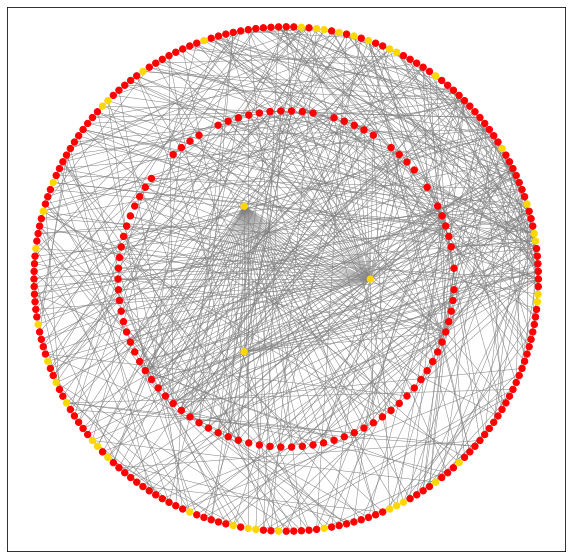

In [201]:
F=3
N=300
M=2
P=0.2
b=1.1

G=newNetwork(N,M,F,P)
#simulate(G)
draw(G)
len(G.graph["mantle"])

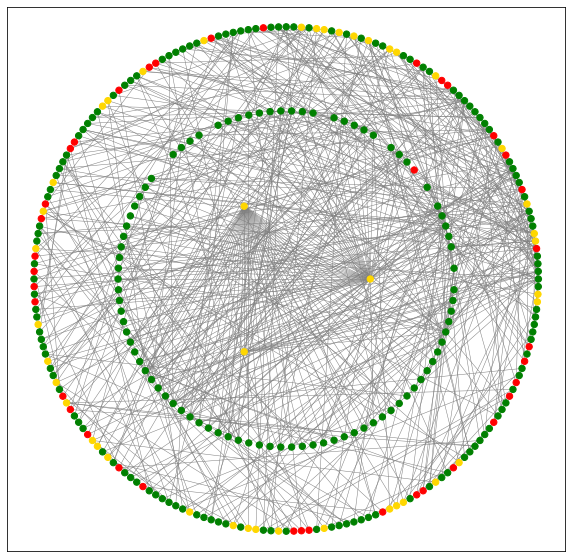

In [211]:
nextRound(G)
draw(G)

In [ ]:
F=3
N=500

B=[1.99]

Nsim=100
p=linspace(0,1,11)


for b in B:
    print (time.strftime("%H:%M:%S", time.gmtime())+" --- b =",b)
    allCR=[]
    for P in p:
        CR=[]
        for sim in range (Nsim):
            G= newNetwork(N,2,F,P)
            simulate(G)
            CR.append(getCoopRatio(G))
        allCR.append(average(CR))
    plot (p,allCR,"o",label="b="+str(b))
    savetxt("disloc-b="+str(b)+".txt",array(allCR))
grid()
legend()
ylim(0,1)
savefig("disloc.png")

08:59:06 --- b = 1.99


08:38:10 --- b = 1.8
08:42:14 --- b = 1.85
08:46:19 --- b = 1.9
08:50:19 --- b = 1.95
08:54:36 --- b = 2.0


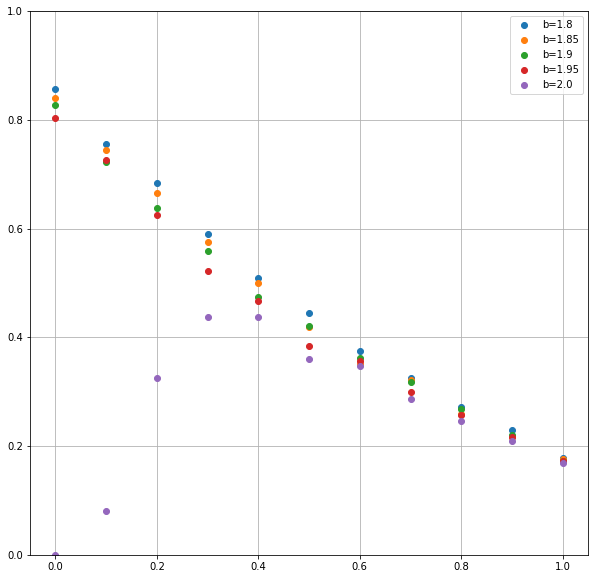

In [212]:
F=3
N=500

B=linspace(1.8,2,5)

Nsim=100
p=linspace(0,1,11)


for b in B:
    print (time.strftime("%H:%M:%S", time.gmtime())+" --- b =",b)
    allCR=[]
    for P in p:
        CR=[]
        for sim in range (Nsim):
            G= newNetwork(N,2,F,P)
            simulate(G)
            CR.append(getCoopRatio(G))
        allCR.append(average(CR))
    plot (p,allCR,"o",label="b="+str(b))
    savetxt("disloc-b="+str(b)+".txt",array(allCR))
grid()
legend()
ylim(0,1)
savefig("disloc.png")

07:57:16 --- b = 1.0
07:59:21 --- b = 1.1666666666666667
08:01:46 --- b = 1.3333333333333333
08:04:40 --- b = 1.5
08:08:08 --- b = 1.6666666666666665
08:11:55 --- b = 1.8333333333333333
08:16:00 --- b = 2.0


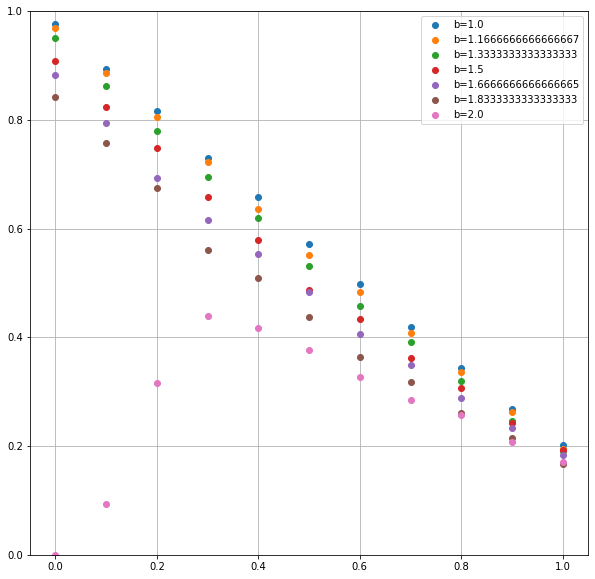

In [113]:
F=3
N=500

B=linspace(1,2,7)

Nsim=100
p=linspace(0,1,11)


for b in B:
    print (time.strftime("%H:%M:%S", time.gmtime())+" --- b =",b)
    allCR=[]
    for P in p:
        CR=[]
        for sim in range (Nsim):
            G= newNetwork(N,2,F,P)
            simulate(G)
            CR.append(getCoopRatio(G))
        allCR.append(average(CR))
    plot (p,allCR,"o",label="b="+str(b))
    savetxt("disloc-b="+str(b)+".txt",array(allCR))
grid()
legend()
ylim(0,1)
savefig("disloc.png")